<a href="https://colab.research.google.com/github/abdulla1osama/text_sentiment_analysis/blob/main/BERT_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers datasets

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Movie_Dataset.csv")
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


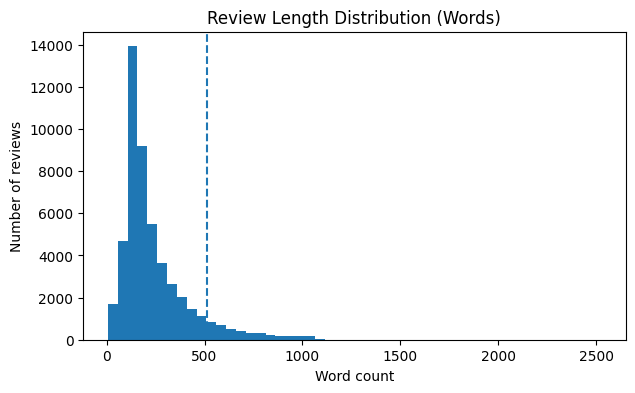

In [ ]:
import re
import matplotlib as mpl

import matplotlib.pyplot as plt

#this prevents matplotlib from parsing $ as math
mpl.rcParams["text.usetex"] = False
mpl.rcParams["text.parse_math"] = False

TEXT_COL = "review"

# word count
df["word_count"] = df[TEXT_COL].apply(lambda x: len(re.findall(r"\b\w+\b", x)))

# histogram
plt.figure(figsize=(7,4))
plt.hist(df["word_count"], bins=50)
plt.axvline(512, linestyle="--")  # BERT token limit shall be 512
plt.xlabel("Word count")
plt.ylabel("Number of reviews")
plt.title("Review Length Distribution (Words)")
plt.show()


In [ ]:
import re

def clean_text(text):
    """
    Clean text by removing HTML tags and URLs while preserving:
    - Stop words
    - Punctuation
    - Sentence structure
    """
    # Ensure text is a string
    if not isinstance(text, str):
        return ""

    # Remove HTML tags (<br />)
    text = re.sub(r'<.*?>', ' ', text)

    # Remove URLs (http/https links)
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove Twitter handles (if any)
    text = re.sub(r'@\w+', '', text)

    # Remove extra whitespace (multiple spaces, tabs, newlines)
    text = re.sub(r'\s+', ' ', text)

    # Strip leading/trailing whitespace
    text = text.strip()

    return text

# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_text)

# Verify
print("First cleaned review:")
print(df['cleaned_review'].iloc[0][:300])

First cleaned review:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this


In [ ]:
from transformers import AutoTokenizer
import torch

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Set maximum length
MAX_LENGTH = 512

# Tokenize the cleaned reviews
def tokenize_data(texts, labels):
    """
    Tokenize text data for BERT
    Returns: input_ids, attention_mask, labels
    """
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,           # Truncate sequences longer than max_length
        padding='max_length',      # Pad sequences shorter than max_length
        max_length=MAX_LENGTH,
        return_tensors='pt'        # Return PyTorch tensors
    )

    return encodings

# Convert sentiment labels to numbers (0 = negative, 1 = positive)
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Tokenize the data
encodings = tokenize_data(df['cleaned_review'], df['label'])

print("=" * 80)
print("TOKENIZATION COMPLETE!")
print("=" * 80)
print(f"\nShape of input_ids: {encodings['input_ids'].shape}")
print(f"Shape of attention_mask: {encodings['attention_mask'].shape}")
print(f"\nNumber of samples: {encodings['input_ids'].shape[0]}")
print(f"Max sequence length: {encodings['input_ids'].shape[1]}")

# Show an example (checked with claude)
print("\n" + "=" * 80)
print("EXAMPLE - First Review:")
print("=" * 80)
print(f"\nOriginal text (first 200 chars):\n{df['cleaned_review'].iloc[0][:200]}")
print(f"\nInput IDs (first 20 tokens):\n{encodings['input_ids'][0][:20]}")
print(f"\nAttention Mask (first 20 tokens):\n{encodings['attention_mask'][0][:20]}")
print(f"\nLabel: {df['label'].iloc[0]} ({df['sentiment'].iloc[0]})")

# Decode tokens back to text to see how tokenization works
print("\n" + "=" * 80)
print("TOKENIZATION BREAKDOWN (First 30 tokens):")
print("=" * 80)
tokens = tokenizer.convert_ids_to_tokens(encodings['input_ids'][0][:30])
for i, token in enumerate(tokens):
    print(f"{i}: {token}")




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

TOKENIZATION COMPLETE!

Shape of input_ids: torch.Size([50000, 512])
Shape of attention_mask: torch.Size([50000, 512])

Number of samples: 50000
Max sequence length: 512

EXAMPLE - First Review:

Original text (first 200 chars):
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was i

Input IDs (first 20 tokens):
tensor([  101,  2028,  1997,  1996,  2060, 15814,  2038,  3855,  2008,  2044,
         3666,  2074,  1015, 11472,  2792,  2017,  1005,  2222,  2022, 13322])

Attention Mask (first 20 tokens):
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Label: 1 (positive)

TOKENIZATION BREAKDOWN (First 30 tokens):
0: [CLS]
1: one
2: of
3: the
4: other
5: reviewers
6: has
7: mentioned
8: that
9: after
10: watching
11: just
12: 1
13: oz
14: episode
15: you
16: '
17: ll
18: be
19: hooked
20: .
21: they
22: are
23: right
24: ,
25

In [ ]:
from transformers import BertForSequenceClassification
import torch

# Load pre-trained BERT model for binary classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification: positive/negative
    output_attentions=False,
    output_hidden_states=False
)


print("MODEL LOADED SUCCESSFULLY!")


# Check total parameters
total_params=sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Freeze early layers (we'll freeze all except the last 2 transformer layers + classifier)
print("FREEZING EARLY LAYERS...")

# Freeze embeddings
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

# Freeze first 10 encoder layers (keep last 2 unfrozen)
for layer in model.bert.encoder.layer[:10]:
    for param in layer.parameters():
        param.requires_grad = False

# Count trainable vs frozen parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("\n" + "=" * 80)
print(f"MODEL MOVED TO: {device}")
print("=" * 80)

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ WARNING: Running on CPU - Training will be VERY slow!")
    print("Please switch to GPU runtime in Colab: Runtime → Change runtime type → GPU")



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MODEL LOADED SUCCESSFULLY!

Total parameters: 109,483,778

FREEZING EARLY LAYERS...

Total parameters: 109,483,778
Trainable parameters: 14,767,874
Frozen parameters: 94,715,904
Percentage trainable: 13.49%

MODEL MOVED TO: cuda
GPU Name: NVIDIA A100-SXM4-40GB
GPU Memory: 42.47 GB

MODEL READY FOR TRAINING!

Configuration:
✓ Pre-trained BERT loaded (trained on Wikipedia + BookCorpus)
✓ Early layers frozen (only fine-tuning last 2 layers + classifier)
✓ Binary classification head attached
✓ Model on GPU (if available)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import  get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import numpy as np
import time

# STEP 1: SPLIT DATA (80% train, 10% validation, 10% test)

print("SPLITTING DATA...")

# Get input_ids, attention_mask, and labels
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
labels = torch.tensor(df['label'].values)

# First split: 80% train, 20% temp (which will become 10% val + 10% test)
train_inputs, temp_inputs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    input_ids, attention_mask, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # Ensures balanced splits
)

# Second split: Split temp into 50% validation and 50% test (10% each of total)
val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_inputs, temp_masks, temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Training samples: {len(train_labels)}")
print(f"Validation samples: {len(val_labels)}")
print(f"Test samples: {len(test_labels)}")


# STEP 2: CREATE DATALOADERS

print("CREATING DATALOADERS...")


BATCH_SIZE = 16  # Use 16 or 32 depending on GPU memory

# Create TensorDatasets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)

# Create DataLoaders
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE
)

val_dataloader = DataLoader(
    val_data,
    sampler=SequentialSampler(val_data),
    batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    test_data,
    sampler=SequentialSampler(test_data),
    batch_size=BATCH_SIZE
)

print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

# STEP 3: SETUP OPTIMIZER AND SCHEDULER

print("SETTING UP OPTIMIZER...")

EPOCHS = 3
LEARNING_RATE = 2e-5

# AdamW optimizer
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=1e-8
)

# Learning rate scheduler with warmup
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Optimizer: AdamW")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Total training steps: {total_steps}")

# ============================================================================
# STEP 4: TRAINING LOOP
# ============================================================================

print("STARTING TRAINING...")

# Store training statistics
training_stats = []

for epoch in range(EPOCHS):
    print(f"\n{'=' * 80}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print('=' * 80)

    # ========================================
    # Training
    # ========================================
    model.train()

    total_train_loss = 0
    train_start_time = time.time()

    for step, batch in enumerate(train_dataloader):
        # Progress update every 50 batches
        if step % 50 == 0 and step != 0:
            elapsed = time.time() - train_start_time
            print(f"  Batch {step}/{len(train_dataloader)} | Elapsed: {elapsed:.2f}s")

        # Move batch to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear gradients
        model.zero_grad()

        # Forward pass
        outputs = model(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass (for differentiation)
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()
        scheduler.step()

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = time.time() - train_start_time

    print(f"\n  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training time: {training_time:.2f}s")

    # ========================================
    # Validation
    # ========================================
    print(f"\n  Running Validation...")

    model.eval()

    total_val_loss = 0
    total_val_accuracy = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # No gradient calculation for validation
        with torch.no_grad():
            outputs = model(
                b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs.loss
        logits = outputs.logits

        total_val_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean()
        total_val_accuracy += accuracy

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_accuracy = total_val_accuracy / len(val_dataloader)

    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {avg_val_accuracy:.4f}")

    # Store stats
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_accuracy': avg_val_accuracy,
        'training_time': training_time
    })

print("\n" + "=" * 80)
print("TRAINING COMPLETE!")
print("=" * 80)

# Display training summary
print("\nTraining Summary:")
for stat in training_stats:
    print(f"\nEpoch {stat['epoch']}:")
    print(f"  Train Loss: {stat['train_loss']:.4f}")
    print(f"  Val Loss: {stat['val_loss']:.4f}")
    print(f"  Val Accuracy: {stat['val_accuracy']:.4f}")
    print(f"  Time: {stat['training_time']:.2f}s")

SPLITTING DATA...
Training samples: 40000
Validation samples: 5000
Test samples: 5000

CREATING DATALOADERS...
Batch size: 16
Training batches: 2500
Validation batches: 313
Test batches: 313

SETTING UP OPTIMIZER...
Optimizer: AdamW
Learning rate: 2e-05
Epochs: 3
Total training steps: 7500

STARTING TRAINING...

Epoch 1/3
  Batch 50/2500 | Elapsed: 7.61s
  Batch 100/2500 | Elapsed: 14.16s
  Batch 150/2500 | Elapsed: 20.73s
  Batch 200/2500 | Elapsed: 27.29s
  Batch 250/2500 | Elapsed: 33.84s
  Batch 300/2500 | Elapsed: 40.40s
  Batch 350/2500 | Elapsed: 46.96s
  Batch 400/2500 | Elapsed: 53.51s
  Batch 450/2500 | Elapsed: 60.07s
  Batch 500/2500 | Elapsed: 66.62s
  Batch 550/2500 | Elapsed: 73.18s
  Batch 600/2500 | Elapsed: 79.74s
  Batch 650/2500 | Elapsed: 86.29s
  Batch 700/2500 | Elapsed: 92.85s
  Batch 750/2500 | Elapsed: 99.40s
  Batch 800/2500 | Elapsed: 105.96s
  Batch 850/2500 | Elapsed: 112.51s
  Batch 900/2500 | Elapsed: 119.06s
  Batch 950/2500 | Elapsed: 125.62s
  Batch 1

EVALUATING ON TEST SET...

TEST SET RESULTS

Accuracy: 0.9316 (93.16%)
F1-Score: 0.9309

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93      2500
    Positive       0.94      0.92      0.93      2500

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



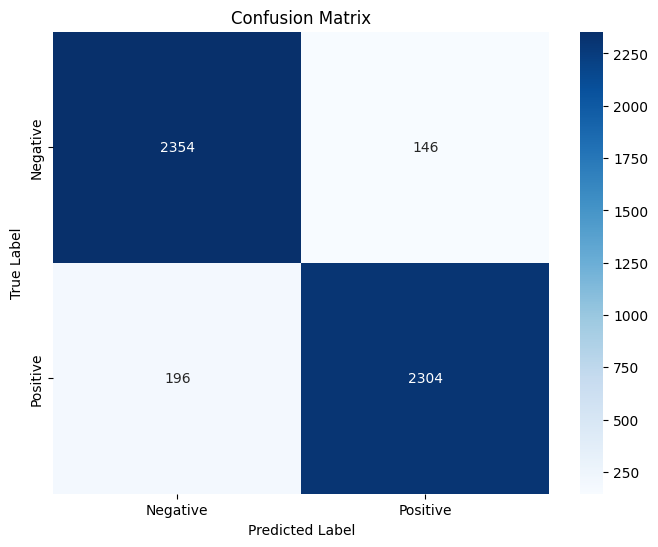


Confusion Matrix:
True Negatives: 2354
False Positives: 146
False Negatives: 196
True Positives: 2304

CREATING INFERENCE PIPELINE...

TESTING INFERENCE PIPELINE

Predictions:
--------------------------------------------------------------------------------

1. Text: "The cinematography was great but the plot was boring"
   Prediction: Negative
   Confidence: 0.9764 (97.64%)
   Probabilities - Negative: 0.9764, Positive: 0.0236

2. Text: "This movie was absolutely amazing! Best film I've seen all year!"
   Prediction: Positive
   Confidence: 0.9960 (99.60%)
   Probabilities - Negative: 0.0040, Positive: 0.9960

3. Text: "Terrible acting and a waste of time. Do not watch this."
   Prediction: Negative
   Confidence: 0.9951 (99.51%)
   Probabilities - Negative: 0.9951, Positive: 0.0049

4. Text: "It was okay, nothing special but not terrible either."
   Prediction: Positive
   Confidence: 0.5228 (52.28%)
   Probabilities - Negative: 0.4772, Positive: 0.5228

5. Text: "I loved every minut

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# STEP 1: EVALUATE ON TEST SET
# ============================================================================
print("=" * 80)
print("EVALUATING ON TEST SET...")
print("=" * 80)

model.eval()

predictions = []
true_labels = []

# Make predictions on test set
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(
            b_input_ids,
            attention_mask=b_input_mask
        )

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).flatten()

    predictions.extend(preds.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())

# Convert to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# ============================================================================
# STEP 2: CALCULATE METRICS
# ============================================================================
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='binary')

print("\n" + "=" * 80)
print("TEST SET RESULTS")
print("=" * 80)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score: {f1:.4f}")

print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))

# ============================================================================
# STEP 3: CONFUSION MATRIX
# ============================================================================
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nConfusion Matrix:")
print(f"True Negatives: {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives: {cm[1][1]}")

# ============================================================================
# STEP 4: INFERENCE PIPELINE
# ============================================================================
print("\n" + "=" * 80)
print("CREATING INFERENCE PIPELINE...")
print("=" * 80)

def predict_sentiment(text, model, tokenizer, device, max_length=512):
    """
    Predict sentiment for a single text input

    Args:
        text: Raw text string
        model: Trained BERT model
        tokenizer: BERT tokenizer
        device: GPU/CPU device
        max_length: Maximum sequence length

    Returns:
        sentiment: 'Positive' or 'Negative'
        confidence: Confidence score (0-1)
    """
    # Clean the text (same cleaning as training)
    text = clean_text(text)

    # Tokenize
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    confidence, predicted_class = torch.max(probabilities, dim=1)

    # Convert to readable format
    sentiment = 'Positive' if predicted_class.item() == 1 else 'Negative'
    confidence_score = confidence.item()

    return sentiment, confidence_score, probabilities[0].cpu().numpy()

# ============================================================================
# STEP 5: TEST INFERENCE WITH EXAMPLES
# ============================================================================
print("\n" + "=" * 80)
print("TESTING INFERENCE PIPELINE")
print("=" * 80)

# Test examples
test_examples = [
    "The cinematography was great but the plot was boring",
    "This movie was absolutely amazing! Best film I've seen all year!",
    "Terrible acting and a waste of time. Do not watch this.",
    "It was okay, nothing special but not terrible either.",
    "I loved every minute of it! The characters were so well developed.",
    "Worst movie ever made. Complete garbage."
]

print("\nPredictions:")
print("-" * 80)

for i, example in enumerate(test_examples, 1):
    sentiment, confidence, probs = predict_sentiment(example, model, tokenizer, device)

    print(f"\n{i}. Text: \"{example}\"")
    print(f"   Prediction: {sentiment}")
    print(f"   Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"   Probabilities - Negative: {probs[0]:.4f}, Positive: {probs[1]:.4f}")

# ============================================================================
# STEP 6: INTERACTIVE PREDICTION FUNCTION
# ============================================================================
print("\n" + "=" * 80)
print("INFERENCE PIPELINE READY!")
print("=" * 80)
print("\nYou can now use the predict_sentiment() function for any text:")
print("\nExample usage:")
print("sentiment, confidence, probs = predict_sentiment('Your text here', model, tokenizer, device)")
print("print(f'Sentiment: {sentiment} (Confidence: {confidence:.2%})')")

# Save the function for easy use
def analyze_review(review_text):
    """Easy-to-use wrapper function"""
    sentiment, confidence, probs = predict_sentiment(review_text, model, tokenizer, device)

    print(f"\n{'='*60}")
    print(f"Review: {review_text}")
    print(f"{'='*60}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"Negative probability: {probs[0]*100:.2f}%")
    print(f"Positive probability: {probs[1]*100:.2f}%")
    print(f"{'='*60}")

    return sentiment, confidence

print("\n✓ Use analyze_review('your text') for quick predictions!")